<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg" 
     width="30%" 
     align=right
     alt="Dask logo">

Custom Workloads
-------------------------

*Because not all problems are dataframes*

This notebook shows using [dask.delayed](http://dask.pydata.org/en/latest/delayed.html) to parallelize generic Python code.  

Dask.delayed is a simple and powerful way to parallelize existing code.  It allows users to delay function calls into a task graph with dependencies.  Dask.delayed doesn't provide any fancy parallel algorithms like Dask.dataframe, but it does give the user complete control over what they want to build.

Systems like Dask.dataframe are built with Dask.delayed.  If you have a problem that is paralellizable, but isn't as simple as just a big array or a big dataframe, then dask.delayed may be the right choice for you.

### Normal Python code

These aren't exciting functions, but hopefully you can see how your functions for your workflow might fit in here.

In [ ]:
from time import sleep

def inc(x):
    from random import random
    sleep(random())
    return x + 1

def dec(x):
    from random import random
    sleep(random())
    return x - 1
    
def add(x, y):
    from random import random
    sleep(random())
    return x + y 

### Run sequentially

In [ ]:
%%time
x = inc(1)
y = dec(2)
z = add(x, y)
z

CPU times: user 640 µs, sys: 956 µs, total: 1.6 ms
Wall time: 2.73 s


3

### Annotate Normal Python functions with Dask

These now become lazy versions.  Rather than compute the result immediately, they record what we want to compute and stick that task into a graph that we'll run later on parallel hardware.

In [ ]:
import dask
inc = dask.delayed(inc)
dec = dask.delayed(dec)
add = dask.delayed(add)

Calling these lazy functions is now almost free.  We're just constructing a graph

In [ ]:
%%time
x = inc(1)
y = dec(2)
z = add(x, y)
z

CPU times: user 305 µs, sys: 55 µs, total: 360 µs
Wall time: 345 µs


Delayed('add-56c5ad3d-0b85-4bf2-ae5c-6b28af9ab009')

### Visualize computation

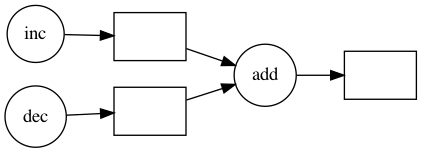

In [ ]:
z.visualize(rankdir='LR')

### Execute with threads on our local machine

In [ ]:
%%time
z.compute()

CPU times: user 8.18 ms, sys: 7.58 ms, total: 15.8 ms
Wall time: 1.28 s


3

### Connect to a cluster and run there

We connect to our cluster.  Now rather than run locally, all of our computations will happen on our cluster.

In [ ]:
from dask.distributed import Client, progress
c = Client('127.0.0.1:8786')
c

Client Scheduler: tcp://127.0.0.1:8786 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 6 Memory: 68.72 GB


In [ ]:
z.compute()

3

### Parallelize Normal Python code

Now we use Dask in normal for-loopy Python code.  This generates graphs instead of doing computations directly, but still looks like the code we had before.  Dask is a convenient way to add parallelism to existing workflows.

In [ ]:
%%time
zs = []
for i in range(256):
    x = inc(i)
    y = dec(x)
    z = add(x, y)
    zs.append(z)
    
zs = dask.persist(*zs)
total = dask.delayed(sum)(zs)

CPU times: user 51.3 ms, sys: 6.84 ms, total: 58.2 ms
Wall time: 54.2 ms


In [ ]:
total.compute()

65536

By looking at the Dask dashboard we can see that Dask spreads this work around our cluster, managing load balancing, dependencies, etc..

### Custom computation: Tree summation

As an example of a non-trivial algorithm, consider the classic tree reduction.  We accomplish this with a nested for loop and a bit of normal Python logic.

```
finish           total             single output
    ^          /        \
    |        c1          c2        neighbors merge
    |       /  \        /  \
    |     b1    b2    b3    b4     neighbors merge
    ^    / \   / \   / \   / \
start   a1 a2 a3 a4 a5 a6 a7 a8    many inputs
```

In [ ]:
L = zs
while len(L) > 1:
    new_L = []
    for i in range(0, len(L), 2):
        lazy = add(L[i], L[i + 1])  # add neighbors
        new_L.append(lazy)
    L = new_L                       # swap old list for new   

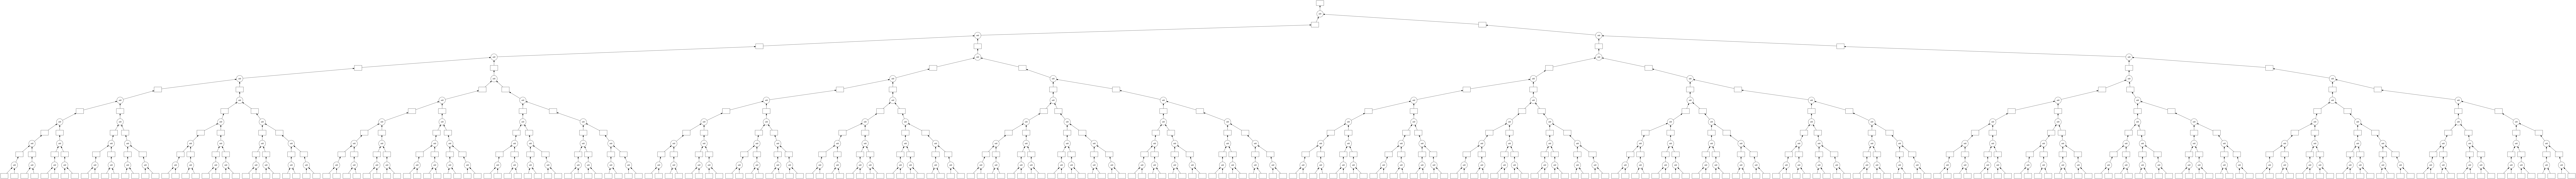

In [ ]:
dask.visualize(*L)

In [ ]:
dask.compute(L)

([65536],)

Note the red bars for inter-worker communication.  Also note how there is lots of parallelism at the beginning but less towards the end as we reach the top of the tree where there is less work to do.